# Introducción

Desde su lanzamiento en Enero de 2008 [pandas](https://pandas.pydata.org/) ha sido la librería de análisis tabular más utilizada dentro del ecosistema Python.

Pandas es una librería muy versátil y con mucho soporte por parte de la comunidad de Data Science.

[scikit-learn](https://scikit-learn.org/stable/), [xgboost](https://xgboost.readthedocs.io/en/stable/) y otras muchas herramientas son compatibles con pandas lo que aumenta su popularidad [(42k estrellas en GitHub)](https://github.com/pandas-dev/pandas) y también extiende su funcionalidad. **No obstante pandas nació con algunas limitaciones que complican su uso para hacer análisis de datasets masivos.**

En los últimos años la librería [polars](https://pola.rs/) ha hecho su aparición dentro del mundo de análisis de datos y ha ganado mucha notoriedad [(26k estrellas en GitHub)](https://github.com/pola-rs/polars).

Dentro del workshop de hoy vamos a hacer una breve introducción a polars y lo vamos a comparar con pandas.

El dataset utilizado para el análisis es [New Yort Taxi and Limousine Comission Tip Dataset](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

Para descargar el dataset, podéis ejecutar el código del notebook [Getting_and_Cleaning_Data.ipynb](./Getting_and_Cleaning_Data.ipynb)

# Los "pecados capitales" de pandas.

El creador de pandas Wes McKinney escribió en detalle sobre algunas de las limitaciones que tiene pandas. Os recomiendo que lean su blog: [Apache Arrow and the “10 Things I Hate About pandas”](https://wesmckinney.com/blog/apache-arrow-pandas-internals/).

Básicamente los principales problemas de pandas según su creador son:

1. **Internals too far from “the metal”.**<br>
1. No support for memory-mapped datasets.<br>
1. Poor performance in database and file ingest/export.<br>
1. Warty missing data support.<br>
1. **Lack of transparency into memory use, RAM management.**<br>
1. Weak support for categorical data.<br>
1. **Complex groupby operations awkward and slow.**<br>
1. Appending data to a DataFrame tedious and very costly.<br>
1. Limited, non-extensible type metadata.<br>
1. **Eager evaluation model, no query planning.**<br>
1. **“Slow”, limited multicore algorithms for large datasets.**<br>

Dentro de este workshop vamos a hablar un poco más en detalle sobre los 5 puntos marcados en **negrita.**

***Nota: el blog anterior fue escrito antes de la aparición de polars en 2020, pero curiosamente polars resuelve algunas de las problemas que se mencionan en el blog.***

---

El punto número 1, **Internals too far from “the metal** se puede resumir en: pandas está escrito en Python y usa como backend numpy (recientemente pandas también ha añadido la posibilidad de usar Arrow como backend).

Esto hace que cuando tenemos un DataFrame **mixto** (strings, números o hasta objetos python en el DataFrame) las operaciones son mucho más lentas.

`In pandas, an array of strings is an array of PyObject pointers, and the actual string data lives inside PyBytes or PyUnicode structs that live all over the process heap.`

---

Pandas consume mucha memoria interna porque en determinas situaciones debe hacer una copia del DataFrame. Si tenemos muchas columnas esto es algo muy ineficiente.

Según el propio Wes McKinney, `pandas rule of thumb: have 5 to 10 times as much RAM as the size of your dataset`.

### Es decir, si nuestro dataset en memoria ocupa 10GB, es recomendable tener entre 50-100GB de RAM para poder trabajar con pandas sin sustos.

---

**Los puntos 7 y 11** están muy relacionados y tienen que ver con que pandas "carga" todo el dataset en memoria para hacer sus cálculos. Lo anterior junto con el **GIL (Global Interpreter Lock)** de Python hacen muy díficil paralelizar operaciones para ganar velocidad por un lado y procesar datasets que no caben en la RAM por el otro lado.

---

Por último pandas únicamente dispone de **Eager mode**. Esto quiere decir que el código se ejecuta según se encuentra. Al no tener un "motor" de ejecución, no hay espacio para optimizar el código (query planner).

# ¿Que es Polars?

Polars es una librería que nació en 2020 y creada por [Ritchie Vink](https://www.ritchievink.com/blog/2021/02/28/i-wrote-one-of-the-fastest-dataframe-libraries/).

Algunas de las diferencias que tiene respecto a pandas son:

1. Está escrita en **Rust**, un lenguaje de programación muy rápido y uno de los más querido según el [stackoverflow survery de 2023](https://survey.stackoverflow.co/2023/).

2. Polars utiliza desde el inicio **Apache Arrow** como forma de representar los datos. Esto hace que el acceso a los datos sea muy rápido y eficiente.

3. Rust permite escribir **código que se ejecuta en paralelo** de manera muy fácil y polars se beneficia enormemente de ello. La mayoría de las operaciones en polars se ejecutan en diferentes threads y se gana mucha velocidad.

4. Polars es según su creador **"un motor de queries con una interfaz de DataFrames"**. Esto implica que tiene dos modos de ejecutar el código: [Eager y Lazy mode](https://docs.pola.rs/user-guide/concepts/lazy-vs-eager/).

**Eager mode al igual que en pandas: el código se ejecuta según se encuentra. No se realiza ninguna optimización de código.**

**Lazy mode por el otro lado permite al motor de ejecución hacer diferentes optimizaciones sobre el código antes de ejecutar la query por este motivo puede llegar a ser mucho más rápido y eficiente.**

Resumen de las dos herramientas:

|Feature   |Polars   |Pandas   |
|---|---|---|
|Lenguaje   |Rust   |Python   |
|Backend   |Arrow   |Numpy o PyArrow|
|Velocidad   |Rápido gracias a Rust, Multicores Compute y Query Planner   |Más rápido que Python puro   |
|Gestión Memoria|Muy eficiente por Rust y cero copias|Copy on Write|
|Lazy Mode|Sí|No|
|Multi Core|Sí by default|No. Tengo que utilizar otras librerías (p.e: Dask)|
|Datasets Masivos|Sí by default|No. Tengo que utilizar otras librerías (p.e: Dask)|
|Facilidad de uso|Las dos librerías son muy fáciles de usar|Las dos librerías son muy fáciles de usar|
|Comunidad y soporte|Librerías más nueva con creciente comunidad|Mucha más documentación y ejemplos|
|Ciclos de desarrollo|Nuevo release cada semana|Mucho más madura|

# Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os

import datetime

import pandas as pd
import polars as pl

pd.options.display.float_format = '{:.3f}'.format
pl.Config.set_float_precision(3);

# GLOBAL_VARS

In [2]:
CWD = os.getcwd()
PATH_INPUT_FOLDER = os.path.join(CWD, "input")

TRIP2401 = os.path.join(PATH_INPUT_FOLDER, "yellow_tripdata_2024-01.parquet")

In [3]:
fs = [f for f in os.listdir(PATH_INPUT_FOLDER) if f != '.ipynb_checkpoints']

In [4]:
print(f"Tenemos un total de {len(fs)} ficheros dentro de nuestra carpeta\n{PATH_INPUT_FOLDER}")

Tenemos un total de 38 ficheros dentro de nuestra carpeta
/Users/nicolaepopescul/Desktop/code/streams/20240512_polars/input


# Pandas vs Polars: métodos básicos

Vamos a cargar los dos datasets en memoria para comparar la sintaxís e ir conociendo polars.

Aquí vamos a utilizar la `API de Eager mode de polars` y por este motivo vamos a utilizar el método de `read_parquet` de polars.

Más adelante veremos los `LazyFrames` de polars.

In [5]:
# pandas
pddf = pd.read_parquet(path = TRIP2401)

In [6]:
# polars


In [7]:
# pandas
pddf.shape

(2964624, 19)

In [8]:
# polars


In [9]:
# pandas
pddf.describe()

,VendorID,TpepPickupDatetime,TpepDropoffDatetime,PassengerCount,TripDistance,RatecodeID,PULocationID,DOLocationID,PaymentType,FareAmount,Extra,MtaTax,TipAmount,TollsAmount,ImprovementSurcharge,TotalAmount,CongestionSurcharge,AirportFee
count,2964624.000,2964624,2964624,2824462.000,2964624.000,2824462.000,2964624.000,2964624.000,2964624.000,2964624.000,2964624.000,2964624.000,2964624.000,2964624.000,2964624.000,2964624.000,2824462.000,2824462.000
mean,1.754,2024-01-17 00:46:36.431095552,2024-01-17 01:02:13.208131328,1.339,3.652,2.069,166.018,165.117,1.161,18.175,1.452,0.483,3.336,0.527,0.976,26.802,2.256,0.141
min,1.000,2002-12-31 22:59:39,2002-12-31 23:05:41,0.000,0.000,1.000,1.000,1.000,0.000,-899.000,-7.500,-0.500,-80.000,-80.000,-1.000,-900.000,-2.500,-1.750
25%,2.000,2024-01-09 15:59:19.750000128,2024-01-09 16:16:23,1.000,1.000,1.000,132.000,114.000,1.000,8.600,0.000,0.500,1.000,0.000,1.000,15.380,2.500,0.000
50%,2.000,2024-01-17 10:45:37.500000,2024-01-17 11:03:51.500000,1.000,1.680,1.000,162.000,162.000,1.000,12.800,1.000,0.500,2.700,0.000,1.000,20.100,2.500,0.000
75%,2.000,2024-01-24 18:23:52.249999872,2024-01-24 18:40:29,1.000,3.110,1.000,234.000,234.000,1.000,20.500,2.500,0.500,4.120,0.000,1.000,28.560,2.500,0.000
max,6.000,2024-02-01 00:01:15,2024-02-02 13:56:52,9.000,312722.300,99.000,265.000,265.000,4.000,5000.000,14.250,4.000,428.000,115.920,1.000,5000.000,2.500,1.750
std,0.433,NaN,NaN,0.850,225.463,9.823,63.624,69.315,0.581,18.950,1.804,0.118,3.897,2.128,0.218,23.386,0.823,0.488


In [10]:
# polars


In [11]:
# pandas
pddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 19 columns):
 #   Column                Dtype         
---  ------                -----         
 0   VendorID              int64         
 1   TpepPickupDatetime    datetime64[ns]
 2   TpepDropoffDatetime   datetime64[ns]
 3   PassengerCount        float64       
 4   TripDistance          float64       
 5   RatecodeID            float64       
 6   StoreAndFwdFlag       object        
 7   PULocationID          int64         
 8   DOLocationID          int64         
 9   PaymentType           int64         
 10  FareAmount            float64       
 11  Extra                 float64       
 12  MtaTax                float64       
 13  TipAmount             float64       
 14  TollsAmount           float64       
 15  ImprovementSurcharge  float64       
 16  TotalAmount           float64       
 17  CongestionSurcharge   float64       
 18  AirportFee            float64       
dtype

In [12]:
# polars


In [13]:
# pandas
pddf.columns.tolist()

['VendorID',
 'TpepPickupDatetime',
 'TpepDropoffDatetime',
 'PassengerCount',
 'TripDistance',
 'RatecodeID',
 'StoreAndFwdFlag',
 'PULocationID',
 'DOLocationID',
 'PaymentType',
 'FareAmount',
 'Extra',
 'MtaTax',
 'TipAmount',
 'TollsAmount',
 'ImprovementSurcharge',
 'TotalAmount',
 'CongestionSurcharge',
 'AirportFee']

In [14]:
# polars


In [15]:
# pandas
pddf.head()

,VendorID,TpepPickupDatetime,TpepDropoffDatetime,PassengerCount,TripDistance,RatecodeID,StoreAndFwdFlag,PULocationID,DOLocationID,PaymentType,FareAmount,Extra,MtaTax,TipAmount,TollsAmount,ImprovementSurcharge,TotalAmount,CongestionSurcharge,AirportFee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.000,1.720,1.000,N,186,79,2,17.700,1.000,0.500,0.000,0.000,1.000,22.700,2.500,0.000
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.000,1.800,1.000,N,140,236,1,10.000,3.500,0.500,3.750,0.000,1.000,18.750,2.500,0.000
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.000,4.700,1.000,N,236,79,1,23.300,3.500,0.500,3.000,0.000,1.000,31.300,2.500,0.000
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.000,1.400,1.000,N,79,211,1,10.000,3.500,0.500,2.000,0.000,1.000,17.000,2.500,0.000
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.000,0.800,1.000,N,211,148,1,7.900,3.500,0.500,3.200,0.000,1.000,16.100,2.500,0.000


In [16]:
# polars


In [17]:
# pandas
pddf.sample(1)

,VendorID,TpepPickupDatetime,TpepDropoffDatetime,PassengerCount,TripDistance,RatecodeID,StoreAndFwdFlag,PULocationID,DOLocationID,PaymentType,FareAmount,Extra,MtaTax,TipAmount,TollsAmount,ImprovementSurcharge,TotalAmount,CongestionSurcharge,AirportFee
1122198,1,2024-01-13 21:03:26,2024-01-13 21:25:25,1.000,3.100,1.000,N,148,68,1,21.200,3.500,0.500,5.200,0.000,1.000,31.400,2.500,0.000


In [18]:
# polars


# .with_columns, .select, .filter ...

In [19]:
# pandas
pddf["PassengerCount"].mean()

1.3392808966805005

In [20]:
# polars


### `Came for speed, stayed for the syntax.`

Dentro de polars hay una sintaxis específica que se recomienda seguir.

Vamos a ver algunas "peculiaridades de la sintaxis de polars".

* Para seleccionar una columna debemos usar `.select`

En polars al `.select` se le conoce como `contexto` y es el **"entorno"** donde se van a evaluar `expresiones de polars`.

Existen otros contextos dentro de polars. Por ejemplo: `group_by`, `select`, `filter` son todo contextos de polars.

Por el otro lado, podemos pensar en `expresiones` como operaciones que queremos que se evaluen y ejecuten dentro de un contexto. Por ejemplo: `sum`, `min`, `max` etc. son todo expresiones que se pueden evaluar dentro de determinados contextos.

In [21]:
# polars

* Si queremos crear una nueva columna debemos usar `.with_columns`

In [22]:
# pandas
(
    pddf
    .assign(
        IsNullPassengerCount = pddf["PassengerCount"].isnull()
    )
    ["IsNullPassengerCount"]
    .sum()
)

140162

In [23]:
# polars

Polars distingue entre `nulls` y `nans`.

Los `nulls` son valores `missing` dentro de nuestro dataset.

Los `nans` por el otro lado son `not a number`. Por ejemplo: `infinito`.

In [24]:
# pandas
(
    pddf
    [["PassengerCount"]]
    .assign(
        IsNullPassengerCount = pddf["PassengerCount"].isnull(),
        IsNanPassengerCount = pddf["PassengerCount"].isna()
    )
    .drop(columns = "PassengerCount")
    .sum()
    .to_frame()
    .T
)

,IsNullPassengerCount,IsNanPassengerCount
0,140162,140162


In [25]:
# polars

In [26]:
# polars

* Cuando queremos filtrar un dataframe podemos utilizar el método de `.filter` de polars.

In [27]:
# pandas
(
    pddf[(pddf["VendorID"] == 1) & (~pddf["PassengerCount"].isnull())]
    .groupby(["StoreAndFwdFlag"])
    .agg(
        MinFareAmount = ("FareAmount", min),
        MeanFareAmount = ("FareAmount", "mean"),
        MaxFareAmount = ("FareAmount", max)
    )
    .sort_index()
    .reset_index()
)

,StoreAndFwdFlag,MinFareAmount,MeanFareAmount,MaxFareAmount
0,N,0.000,17.573,5000.000
1,Y,0.000,17.638,245.900


In [28]:
# polars

# .group_by 

In [29]:
# pandas
(
    pddf[
        (
            (pddf["TpepPickupDatetime"] >= datetime.datetime(2024, 1, 1)) &
            (pddf["TpepPickupDatetime"] <= datetime.datetime(2024, 2, 1))
        ) &
        (~pddf["PassengerCount"].isnull())
    ]
    .assign(DayOfWeek = pddf["TpepPickupDatetime"].dt.weekday + 1)
    .groupby("DayOfWeek")
    .agg(TotalTripDistance = ("TripDistance", sum))
    .sort_values(by = "DayOfWeek", ascending = True)
)

,TotalTripDistance
DayOfWeek,
1,1409121.140
2,1420449.070
3,1527454.120
4,1306296.010
5,1236050.240
6,1170552.520
7,1121015.710


In [30]:
# polars

# Plots

Tanto pandas como polars tienen capacidad para realizar gráficos desde la propia librería.

Pandas utiliza [Matplotlib](https://matplotlib.org/) mientras que polars utiliza [hvPlot](https://hvplot.holoviz.org/).

<Axes: xlabel='VendorID'>

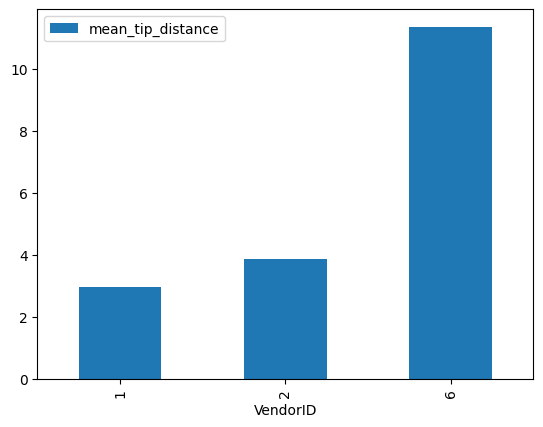

In [31]:
# pandas
(
    pddf
    .groupby(by = ["VendorID"])
    .agg(
        max_passenger_count = ("PassengerCount", max),
        min_passenger_count = ("PassengerCount", min),
        mean_tip_distance = ("TripDistance", "mean")
    )
    .reset_index()
    .sort_values("VendorID")
    [["VendorID", "mean_tip_distance"]]
    .plot(kind = "bar", x = "VendorID")
)

In [32]:
# polars

# Lazy Mode

Cuando utilizamos cualquier de los métodos de polars que empiezan por `scan_` estamos usando el `Lazy Mode` de polars.

Esto implica que: 
1. No estamos cargando el dataset en memoria.
2. El query planner puede hacer algunas optimizaciones de nuestro código.

In [33]:
plldf = pl.scan_parquet(source = os.path.join(PATH_INPUT_FOLDER, f"yellow_*.parquet"))

In [34]:
plldf

In [35]:
p = (
    plldf
    .filter(
        (pl.col("TpepPickupDatetime").is_between(
            lower_bound = datetime.datetime(2024, 1, 1),
            upper_bound = datetime.datetime(2024, 2, 1)
        )) &
        (~pl.col("PassengerCount").is_null())
    )
    .with_columns(
        DayOfWeek = pl.col("TpepPickupDatetime").dt.weekday(),
        FlagPassengerCount = pl.col("PassengerCount") >= 3
    )
    .select(pl.col(["TpepPickupDatetime", "DayOfWeek", "FlagPassengerCount"]))
)

In [36]:
p

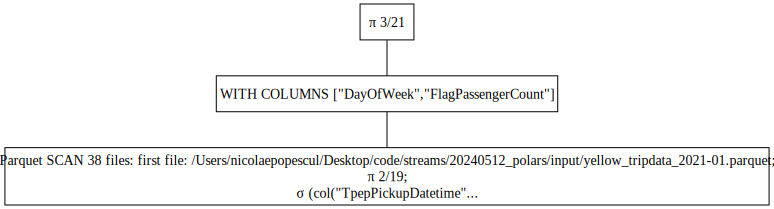

In [37]:
p.show_graph(optimized=True)

In [38]:
(
    plldf
    .select(pl.all().is_null())
    .sum()
    .collect()
    .transpose()
    .rename({"column_0":"nulls"})
    .filter(pl.col("nulls") > 0)
)

nulls
u32
4482126
4482126
4482126
4482126
8644849


In [39]:
(
    plldf.collect().shape
)

(114842782, 19)

In [40]:
(
    plldf.collect().estimated_size("gb")
)

15.509882331825793

In [41]:
plldf.head().collect()

VendorID,TpepPickupDatetime,TpepDropoffDatetime,PassengerCount,TripDistance,RatecodeID,StoreAndFwdFlag,PULocationID,DOLocationID,PaymentType,FareAmount,Extra,MtaTax,TipAmount,TollsAmount,ImprovementSurcharge,TotalAmount,CongestionSurcharge,AirportFee
i64,datetime[ns],datetime[ns],f64,f64,f64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.000,2.100,1.000,"""N""",142,43,2,8.000,3.000,0.500,0.000,0.000,0.300,11.800,2.500,null
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.000,0.200,1.000,"""N""",238,151,2,3.000,0.500,0.500,0.000,0.000,0.300,4.300,0.000,null
1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.000,14.700,1.000,"""N""",132,165,1,42.000,0.500,0.500,8.650,0.000,0.300,51.950,0.000,null
1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.000,10.600,1.000,"""N""",138,132,1,29.000,0.500,0.500,6.050,0.000,0.300,36.350,0.000,null
2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.000,4.940,1.000,"""N""",68,33,1,16.500,0.500,0.500,4.060,0.000,0.300,24.360,2.500,null


In [42]:
# %%timeit

# Conclusión

Tras este breve workshop, podemos extrar algunas conclusiones:
1. Tanto pandas como polars son excelentes librerás para hacer análisis de datos.
2. Pandas es una excelente opción siempre y cuando tenemos datasets pequeños y que caben en memoria.
3. Pandas también es una librería mucho más madura que polars y que tiene mucha documentación y ejemplos.
4. Polars es una de las mejores opciones cuando tenemos que trabajar con dataset grandes que no caben en memoria y no podemos utilizar tecnologías Big Data.
5. Polars está en fase activa de desarrollo.

Recomendación personal: si vas a empezar un nuevo proyecto utiliza polars (aprender la librería etc).

No hagan "grandes migraciones de código" porque es muy costoso a nivel de tiempo.

Si caso de echar en falta algo de pandas, siempre pueden utilizar `.to_pandas()`